In [3]:
import pandas as pd
import numpy as np

def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df

In [4]:
# Load data
train_df = pd.read_csv('../data/raw/train.csv')
weather_df = pd.read_csv('../data/raw/weather_train.csv')
building_df = pd.read_csv('../data/raw/building_metadata.csv')

# Reduce memory immediately
train_df = reduce_mem_usage(train_df)
weather_df = reduce_mem_usage(weather_df)
building_df = reduce_mem_usage(building_df)

# Merge
# 1. Join building metadata on building_id
train_df = train_df.merge(building_df, on='building_id', how='left')

# 2. Join weather on site_id and timestamp
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])

train_df = train_df.merge(weather_df, on=['site_id', 'timestamp'], how='left')

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%


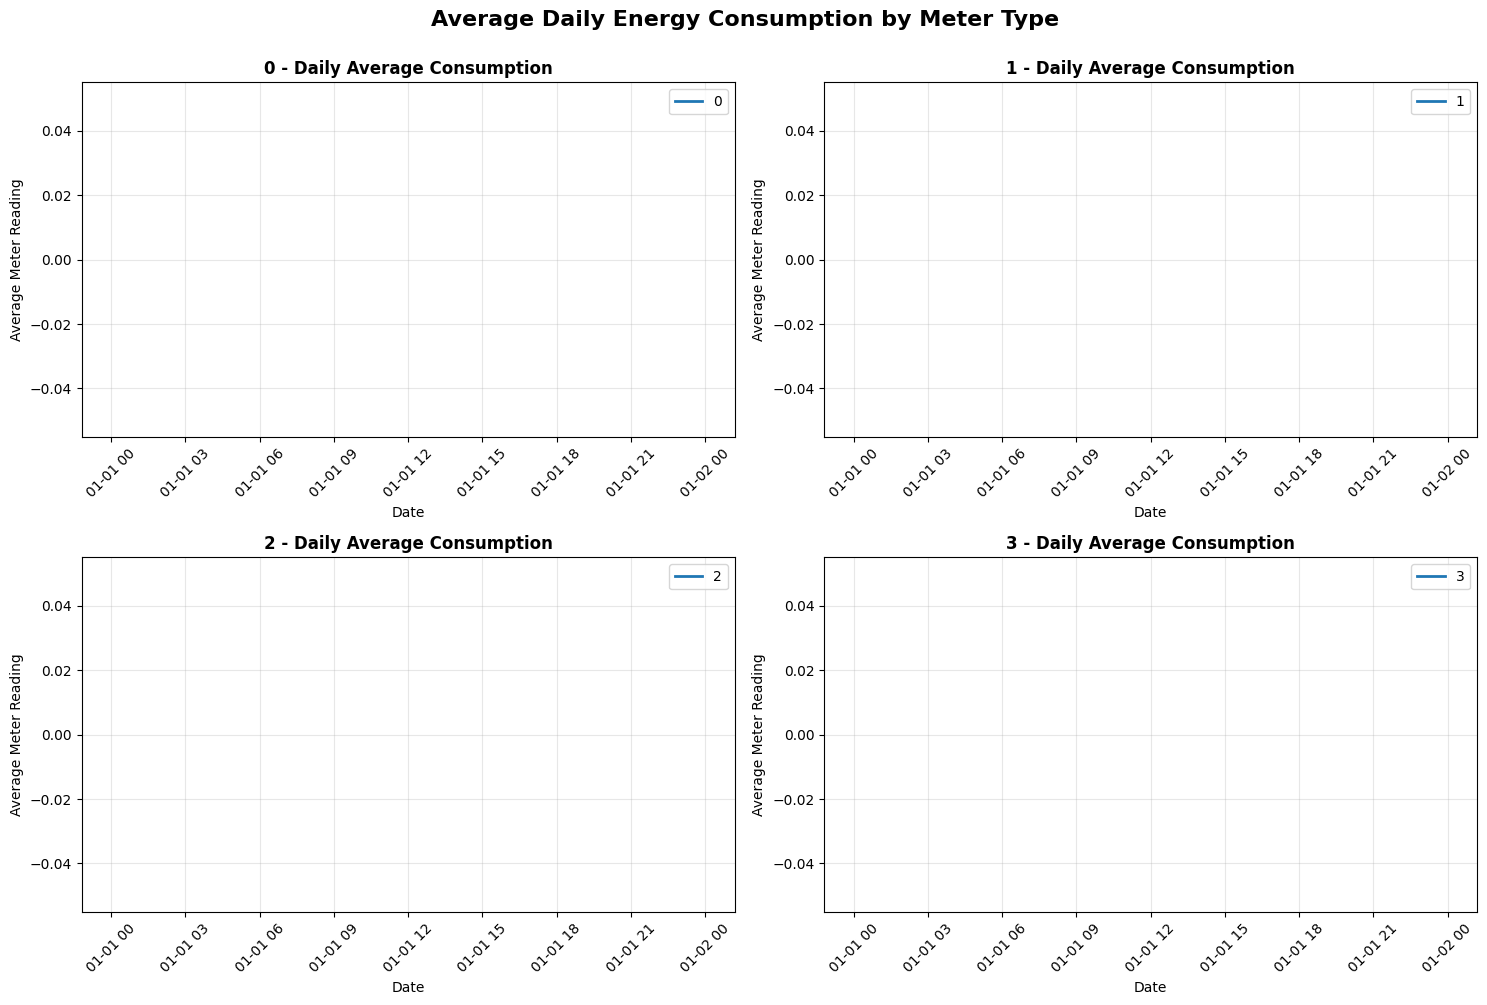

In [ ]:
import matplotlib.pyplot as plt
# Get unique meter types
daily_avg = train_df.set_index('timestamp').groupby('meter').resample('D')['meter_reading'].mean().reset_index()
meter_mapping = {0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}
daily_avg['meter_name'] = daily_avg['meter'].map(meter_mapping)
meter_types = daily_avg['meter'].unique()

# Create subplots - 2x2 grid for 4 meter types
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily iterate

# Plot each meter type on its own subplot
for idx, meter in enumerate(meter_types):
    meter_data = daily_avg[daily_avg['meter_name'] == meter]
    
    axes[idx].plot(meter_data['timestamp'], meter_data['meter_reading'], 
                   linewidth=2, label=meter)
    axes[idx].set_title(f'{meter} - Daily Average Consumption', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Average Meter Reading', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Average Daily Energy Consumption by Meter Type', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()